## 7) 네이버 쇼핑 리뷰 감성 분류하기(Naver Shopping Review Sentiment Analysis)

이번에 사용할 데이터는 네이버 쇼핑 리뷰 데이터이다. 총 200,000개 리뷰로 구성된 데이터로 평점이 5점 만점에 1, 2, 4, 5인 리뷰들로 구성된 데이터이다. 3점인 리뷰는 긍정, 부정 유무가 애매하여 데이터 구성 시에 제외되었다. 평점이 4, 5인 리뷰들에 긍정을 의미하는 레이블 1을, 평점이 1, 2인 리뷰들에 부정을 의미하는 레이블 0을 부여하고, 감성 분류를 수행하는 모델을 만들어보겠다.


### 1.Colab에 Mecab 설치

이번 챕터에서는 형태소 분석기 Mecab을 사용한다. 여기서는 Mecab을 편하게 사용하기 위해서 구글의 Colab을 사용하였다. 우선, Colab에서 Mecab을 설치한다. 참고로 윈도우에서는 Mecab 설치 방법이 다르기 때문에 아래 커맨드를 주피터 노트북에 입력하더라도 Mecab이 설치되지 않는다. 그래서 가급적 저자와 같은 환경인 Colab에서 실습을 권장한다.


In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 75 (delta 33), reused 21 (delta 5), pack-reused 0
Unpacking objects: 100% (75/75), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4MB 167kB/s 
     |████████████████████████████████| 92kB 10.3MB/s 
     |████████████████████████████████| 460kB 54.4MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-01-12 10:06:19--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz

### 2.네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리

다운로드 링크 : https://github.com/bab2min/corpus/tree/master/sentiment


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
import urllib.request

from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 1) 데이터 로드하기

위의 링크로부터 전체 데이터에 해당하는 ratings_total.txt를 다운로드한다.


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt",
                           filename="ratings_total.txt")


('ratings_total.txt', <http.client.HTTPMessage at 0x7f58c6b207f0>)

해당 데이터에는 열제목이 별도로 없다. 그래서 임의로 두 개의 열제목인 'ratings'와 'reviews'를 추가해주겠다.



In [4]:
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])
print('전체 리뷰 개수 :', len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


총 20만개의 샘플이 존재한다. 상위 5개의 샘플만 출력해보자.


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


#### 2) 훈련 데이터와 테스트 데이터 분리하기

현재 갖고 있는 데이터는 레이블을 별도로 갖고 있지 않다. 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여한다. 부여된 레이블은 새로 생성한 label이라는 열에 저장한다.

In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default = 0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


각 열에 대해서 중복을 제외한 샘플의 수를 카운트한다.



In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()


(4, 199908, 2)

ratings열의 경우 1, 2, 4, 5라는 네 가지 값을 가지고 있다. reviews열에서 중복을 제외한 경우 199,908개이다. 현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미이다. 중복인 샘플들을 제거해준다.


In [8]:
total_data.drop_duplicates(subset = ['reviews'], inplace = True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :', len(total_data))

총 샘플의 수 : 199908


NULL 값 유무를 확인한다.


In [9]:
print(total_data.isnull().values.any())

False


훈련 데이터와 테스트 데이터를 3:1 비율로 분리한다.


In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, 
                                         random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


훈련용 리뷰의 경우 약 14만 9,900개. 테스트용 리뷰의 경우 약 4만 9,900개가 존재한다.


#### 3) 레이블의 분포 확인

훈련 데이터의 레이블의 분포를 확인해보자.


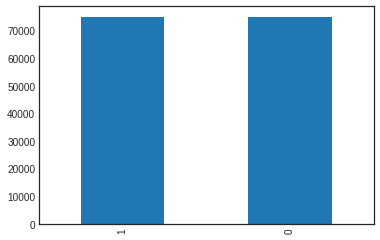

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


두 레이블 모두 약 7만 5천개로 50:50 비율을 가지고 있다.


#### 4) 데이터 정제하기

정규 표현식을 사용하여 한글을 제외하고 모두 제거해준다. 또한 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인한다.


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


테스트 데이터에 대해서도 같은 과정을 거친다.


In [14]:
test_data.drop_duplicates(subset = ['reviews'], inplace = True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace = True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how = 'any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :', len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

#### 5) 토큰화

형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행한다. 다음은 임의의 문장에 대해서 테스트한 토큰화 결과이다.


In [15]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


불용어를 지정하여 필요없는 토큰들은 제거하도록 한다.


In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


훈련 데이터와 테스트 데이터에 대해서 동일한 과정을 거친다.


In [17]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


#### 6) 단어와 길이 분포 확인하기

긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해준다.



In [19]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


Counter()를 사용하여 각 단어에 대한 빈도수를 카운트한다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력한다.


In [20]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


'네요', '는데', '안', '않', '너무', '없' 등과 같은 단어들이 부정 리뷰에서 주로 등장한다. 긍정 리뷰에 대해서도 동일하게 출력해보자.


In [21]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


'좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장한다. 두 가지 경우에 대해서 각각 길이 분포를 확인해보자.



긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029525614672043


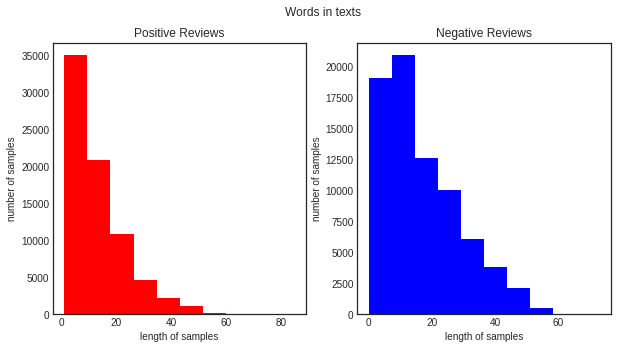

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))

ax1.hist(text_len, color = 'red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))

ax2.hist(text_len, color = 'blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향이 있는 것 같다.


In [23]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test = test_data['tokenized'].values
y_test = test_data['label'].values

#### 7) 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 한다. 우선, 훈련 데이터에 대해서 단어 집합(vocabulary)을 만들어보자.


In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 이는 tokenizer.word_index를 출력하여 확인 가능하다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 한다. 이 단어들이 이 데이터에서 얼마만큼의 비중을 차지하는지 확인해보자.



In [25]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt) * 100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀 단어의 수: 18213
단어 집합에서 희귀 단어의 비율: 45.53477673883694
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935684918495074


단어가 약 40,000개가 존재한다. 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 45%를 차지한다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%밖에 되지 않는다. 아무래도 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 하다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠다.

등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠다.


In [26]:
# 전체 단어 개수 중 빈도수 2 이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21787


이제 단어 집합의 크기는 21,787개이다. 이를 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환한다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠다.


In [27]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

정수 인코딩이 진행되었는지 확인하고자 X_train과 X_test에 대해서 상위 3개의 샘플만 출력한다.


In [28]:
print(X_train[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [29]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


#### 8) 패딩

이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠다.



리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.30754813881052


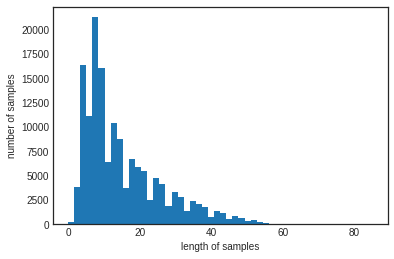

In [30]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train)) / len(X_train))

plt.hist([len(s) for s in X_train], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이는 85, 평균 길이는 약 15이다. 그리고 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보인다.



In [31]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if (len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' % (max_len, (cnt / len(nested_list)) * 100))
    

최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인해보자.


In [32]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


훈련용 리뷰의 99.99%가 80이하의 길이를 가진다. 훈련용 리뷰를 길이 80으로 패딩하겠다.


In [33]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test  = pad_sequences(X_test , maxlen = max_len)


### 3.GRU로 네이버 쇼핑 리뷰 감성 분류하기


In [34]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2178700   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,267,149
Trainable params: 2,267,149
Non-trainable params: 0
_________________________________________________________________


In [36]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', 
                     verbose = 1, save_best_only = True)


In [37]:
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])

In [38]:
hist = model.fit(X_train, y_train,
                 epochs = 15, 
                 callbacks = [es, mc],
                 batch_size = 60,
                 validation_split = 0.2)

Epoch 1/15
2000/2000 [==============================] - 37s 14ms/step - loss: 0.3268 - acc: 0.8668 - val_loss: 0.2305 - val_acc: 0.9158

Epoch 00001: val_acc improved from -inf to 0.91580, saving model to best_model.h5
Epoch 2/15
2000/2000 [==============================] - 28s 14ms/step - loss: 0.2158 - acc: 0.9209 - val_loss: 0.2166 - val_acc: 0.9196

Epoch 00002: val_acc improved from 0.91580 to 0.91957, saving model to best_model.h5
Epoch 3/15
2000/2000 [==============================] - 27s 14ms/step - loss: 0.1988 - acc: 0.9279 - val_loss: 0.2157 - val_acc: 0.9222

Epoch 00003: val_acc improved from 0.91957 to 0.92217, saving model to best_model.h5
Epoch 4/15
2000/2000 [==============================] - 27s 13ms/step - loss: 0.1868 - acc: 0.9334 - val_loss: 0.2011 - val_acc: 0.9275

Epoch 00004: val_acc improved from 0.92217 to 0.92747, saving model to best_model.h5
Epoch 5/15
2000/2000 [==============================] - 27s 13ms/step - loss: 0.1778 - acc: 0.9379 - val_loss: 0.20

In [39]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도: %.4f' % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 6s 3ms/step - loss: 0.2066 - acc: 0.9261

 테스트 정확도: 0.9261


### 4.리뷰 예측해보기


In [40]:
def sentiment_predict(new_sentence):
    new_sentence = mecab.morphs(new_sentence)
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if (score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [41]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

98.17% 확률로 긍정 리뷰입니다.


In [42]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.16% 확률로 부정 리뷰입니다.


In [43]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

97.97% 확률로 긍정 리뷰입니다.


In [47]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

90.66% 확률로 부정 리뷰입니다.
